<a href="https://colab.research.google.com/github/RanojoyBiswas/PySpark-Practice/blob/main/Logistic_Regression_on_Titanic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Logistic').getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Pyspark Practice/Python-and-Spark-for-Big-Data-master/Spark_for_Machine_Learning/Logistic_Regression/titanic.csv',
                    inferSchema = True, header = True)

In [ ]:
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [ ]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [ ]:
# total records
df.count()

891

In [ ]:
from pyspark.sql.functions import isnan, isnull, when, count, col

# assume your dataframe is named 'df'
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
mycols = df.select(['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked'])

In [ ]:
# dropping the null values
data = mycols.na.drop()

In [ ]:
# count of people survived and not survived
data.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  288|
|       0|  424|
+--------+-----+



In [ ]:
data.describe().show()

+-------+------------------+------------------+------+-----------------+------------------+-------------------+------------------+--------+
|summary|          Survived|            Pclass|   Sex|              Age|             SibSp|              Parch|              Fare|Embarked|
+-------+------------------+------------------+------+-----------------+------------------+-------------------+------------------+--------+
|  count|               712|               712|   712|              712|               712|                712|               712|     712|
|   mean|0.4044943820224719| 2.240168539325843|  null|29.64209269662921|0.5140449438202247|0.43258426966292135| 34.56725140449432|    null|
| stddev|0.4911389472541192|0.8368543166903446|  null|14.49293290032352|0.9306921267673427| 0.8541814457454133|52.938648174710906|    null|
|    min|                 0|                 1|female|             0.42|                 0|                  0|               0.0|       C|
|    max|           

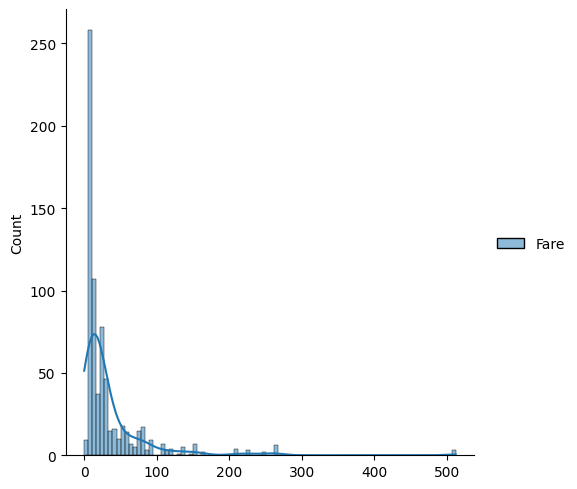

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data.select('Fare').toPandas(), kde=True)
plt.show()

In [ ]:
# parch col
data.groupBy('Parch').count().orderBy('Parch').show()

+-----+-----+
|Parch|count|
+-----+-----+
|    0|  519|
|    1|  110|
|    2|   68|
|    3|    5|
|    4|    4|
|    5|    5|
|    6|    1|
+-----+-----+



In [ ]:
# Pclass col
data.groupBy('Pclass').count().orderBy('Pclass').show()

+------+-----+
|Pclass|count|
+------+-----+
|     1|  184|
|     2|  173|
|     3|  355|
+------+-----+



### Working with Categorical columns

In [ ]:
from pyspark.ml.feature import (VectorAssembler, VectorIndexer,
                                StringIndexer, OneHotEncoder)

In [ ]:
data.show(5)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



In [ ]:
data.columns

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [ ]:
# gender col
gender_indexer = StringIndexer(inputCol = 'Sex', outputCol = 'sex_index')
gender_encoder = OneHotEncoder(inputCol = 'sex_index', outputCol = 'sex_vec')

In [ ]:
# Embarked col
embarked_indexer = StringIndexer(inputCol = 'Embarked', outputCol = 'Embarked_index')
embarked_encoder = OneHotEncoder(inputCol = 'Embarked_index', outputCol = 'Embarked_vec')

In [ ]:
assembler = VectorAssembler(inputCols = ['Pclass', 'sex_vec', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_vec'],
                           outputCol = 'features')

In [ ]:
# importing Logistic reg
from pyspark.ml.classification import LogisticRegression

### Pipeline

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'Survived')

In [ ]:
ppl = Pipeline(stages=[gender_indexer, embarked_indexer, 
                      gender_encoder, embarked_encoder,
                      assembler, log_reg])

In [ ]:
# train-test split
train_data, test_data = data.randomSplit([0.8,0.2])

In [ ]:
model = ppl.fit(train_data)

In [ ]:
res = model.transform(test_data)

In [ ]:
# res.show()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evals = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Survived')

In [ ]:
res.select(['Survived', 'prediction']).show()

+--------+----------+
|Survived|prediction|
+--------+----------+
|       0|       1.0|
|       0|       0.0|
|       0|       1.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [ ]:
auc_score = evals.evaluate(res)

In [ ]:
# model score
auc_score

0.7797135114208285